In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import re

In [ ]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd ..
%cd gdrive/MyDrive/disaster_nlp

/
/gdrive/MyDrive/disaster_nlp


In [ ]:
# import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ids = test.id
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# function to remove html tags in text
def htmlremove(text):
    return re.sub('<[^<]+?>', '', text)

train['text'] = train['text'].apply(htmlremove)
test['text'] = test['text'].apply(htmlremove)  

In [ ]:
# remove url and @'s
def urlremove(text):
    return re.sub(r"(?:\@|https?\://)\S+", "", text)

train['text'] = train['text'].apply(urlremove)
test['text'] = test['text'].apply(urlremove)

In [ ]:
# remove emojis
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emoji(text):
    emoji_pattern = re.compile(
        u"(\ud83d[\ude00-\ude4f])|"  # emoticons
        u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
        u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
        u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
        u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
        "+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['text'] = train['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_emoji)

In [ ]:
# remove contractions
# taken from: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(text):
    if '’' in text:
        text = text.replace("’", "'")
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

train['text'] = train['text'].apply(decontracted)
test['text'] = test['text'].apply(decontracted)

In [ ]:
# remove special characters
def characterremove(text):
    return re.sub('\W+|_', ' ', text)

train.text = train.text.apply(characterremove)
test.text = test.text.apply(characterremove)

In [ ]:
# remove numbers in text
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

train.text = train.text.apply(remove_numbers)
test.text = test.text.apply(remove_numbers)

In [ ]:
train.text = train.text.str.lower()
train.text = train.text.str.strip()

test.text = test.text.str.lower()
test.text = test.text.str.strip()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))  
lemmer = WordNetLemmatizer()
train.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ') if word not in stop_words]) for text in train.text]

test.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ') if word not in stop_words]) for text in test.text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


average tweet length: 58.47773545251543


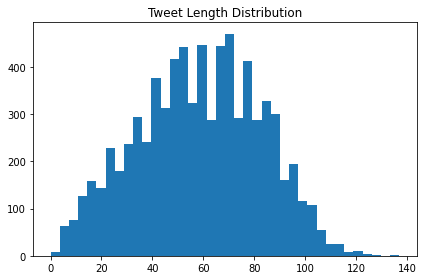

In [ ]:
lens = []
for tweet in train.text:
  lens.append(len(tweet))

plt.hist(lens, bins='auto')
plt.title('Tweet Length Distribution')
plt.tight_layout()
print('average tweet length: {}'.format(np.mean(lens)))

In [ ]:
MAX_LEN = 70
BUFFER_SIZE = 10000
BATCH_SIZE = 4
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12741 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(train.text)
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', maxlen=MAX_LEN)
y = np.asarray(train.target).astype('float32').reshape((-1,1))
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 3892,  461,  162,
         73, 1399, 3893,    4], dtype=int32)

In [ ]:
data = tf.data.Dataset.from_tensor_slices((X, y))
data = data.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=False).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-01-31 22:49:39--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.246|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
VOCAB_SIZE = len(word_index)+1 
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, index in word_index.items():
  try:
    embedding_vector = word2vec[word]
    embedding_matrix[index] = embedding_vector
  except:
    continue

In [ ]:
embedding_matrix.shape

(12742, 300)

In [ ]:
TRAIN_SIZE = int(0.85 * (len(X)//BATCH_SIZE))
data = data.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=False)
train_data = data.take(TRAIN_SIZE)
val_data = data.skip(TRAIN_SIZE)


In [ ]:
  def build_model(batch_size, dropout):
    model = Sequential()
    model.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights = [embedding_matrix], 
                    input_length=MAX_LEN, batch_size=batch_size))
    # model.add(layers.Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=MAX_LEN, batch_size=batch_size))
    # model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

  
model = build_model(BATCH_SIZE, 0.5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (4, 70, 300)              3822600   
_________________________________________________________________
bidirectional (Bidirectional (4, 70, 128)              186880    
_________________________________________________________________
dropout (Dropout)            (4, 70, 128)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (4, 128)                  98816     
_________________________________________________________________
dropout_1 (Dropout)          (4, 128)                  0         
_________________________________________________________________
dense (Dense)                (4, 1)                    129       
Total params: 4,108,425
Trainable params: 4,108,425
Non-trainable params: 0
______________________________________________

In [ ]:
epochs = 5              
# def perplexity(labels, preds):
#     return keras.backend.exp(tf.keras.losses.categorical_crossentropy(labels, preds))

def loss(labels, logits):
  return tf.keras.losses.binary_crossentropy(labels, logits)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5, epsilon=1e-8)
  
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) 

history = model.fit(train_data, epochs=epochs, validation_data=val_data)

Epoch 1/5
1617/1617 [==============================] - 317s 192ms/step - loss: 0.6338 - accuracy: 0.6544 - val_loss: 0.4578 - val_accuracy: 0.8007
Epoch 2/5
1617/1617 [==============================] - 309s 191ms/step - loss: 0.4829 - accuracy: 0.7844 - val_loss: 0.4336 - val_accuracy: 0.8147
Epoch 3/5
1617/1617 [==============================] - 313s 193ms/step - loss: 0.4549 - accuracy: 0.7989 - val_loss: 0.4237 - val_accuracy: 0.8191
Epoch 4/5
1617/1617 [==============================] - 311s 192ms/step - loss: 0.4367 - accuracy: 0.8075 - val_loss: 0.4211 - val_accuracy: 0.8287
Epoch 5/5
1617/1617 [==============================] - 311s 192ms/step - loss: 0.4223 - accuracy: 0.8194 - val_loss: 0.4209 - val_accuracy: 0.8295


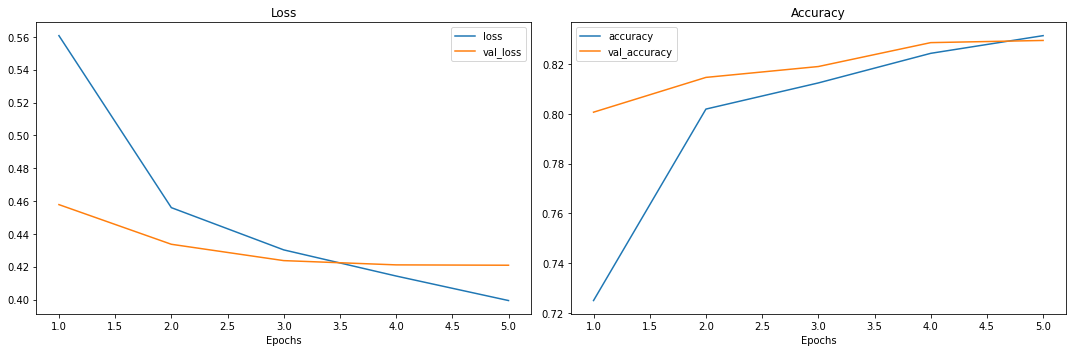

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(1, epochs+1), history.history['loss'], label='loss')
ax[0].plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_title('Loss')

ax[1].plot(range(1, epochs+1), history.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epochs+1), history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_title('Accuracy')

plt.tight_layout()

In [ ]:
model.save_weights('model_weights.hdf5')
# build model of batch 1 for evaluation
model1 = build_model(1, 0.5)
model1.load_weights('model_weights.hdf5')

In [ ]:
X_test = tokenizer.texts_to_sequences(test.text)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre', maxlen=MAX_LEN)
test_data = tf.data.Dataset.from_tensor_slices((X_test))
test_data = test_data.batch(1)

In [ ]:
from google.colab import files
test['target']= model1.predict_classes(test_data)
test_export = test.loc[:, ['id', 'target']]
test_export.to_csv('w2v_blstm.csv', index=False) 
files.download('w2v_blstm.csv')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>